<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Simple_conv_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN

In [1]:
from IPython import display

In [2]:
!pip install -q --upgrade wandb
display.clear_output()

In [3]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision import datasets
from tqdm import *

import wandb

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

%matplotlib inline


[INFO] Couldn't find torchinfo... installing it.


##Tensors and images

<ipython-input-4-6d49eca8d0e9>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(url)


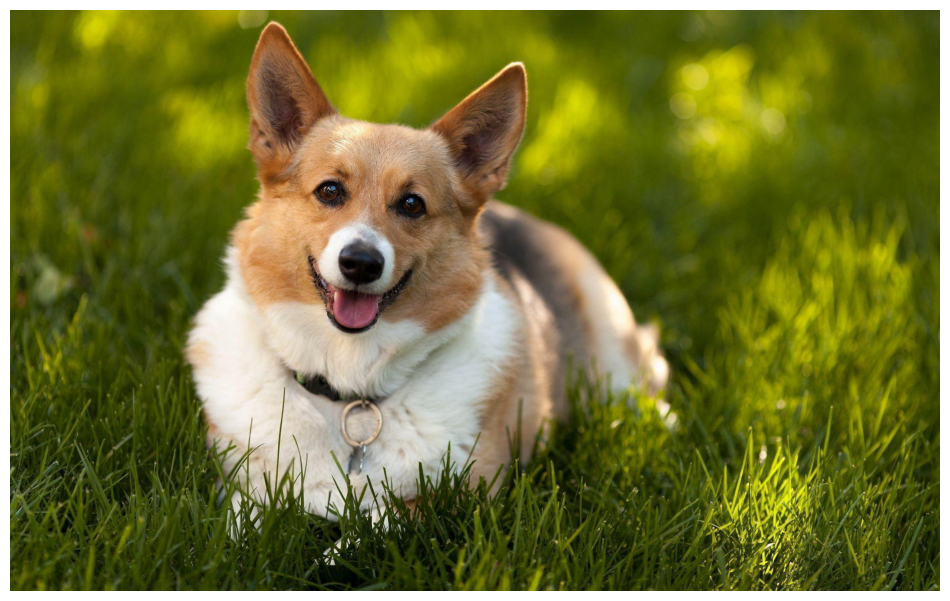

In [4]:
def url_to_image(url):
    image = imageio.imread(url)
    return image

img = url_to_image('https://www.teahub.io/photos/full/236-2368950_happy-corgi-wallpaper-corgi-hd.jpg')

plt.figure(figsize = (12, 8))
plt.imshow(img)
plt.axis("off");

## Task №1. Apply filters Sharpen, Gaussian Blur, Left Sobel Filter и Right Sobel Filter.

In [5]:
def make_filter(ilist:list):
  array = np.array(ilist).astype('float32')
  filtered = cv2.filter2D(img, -1, array)
  return filtered

(([], []), ([], []))

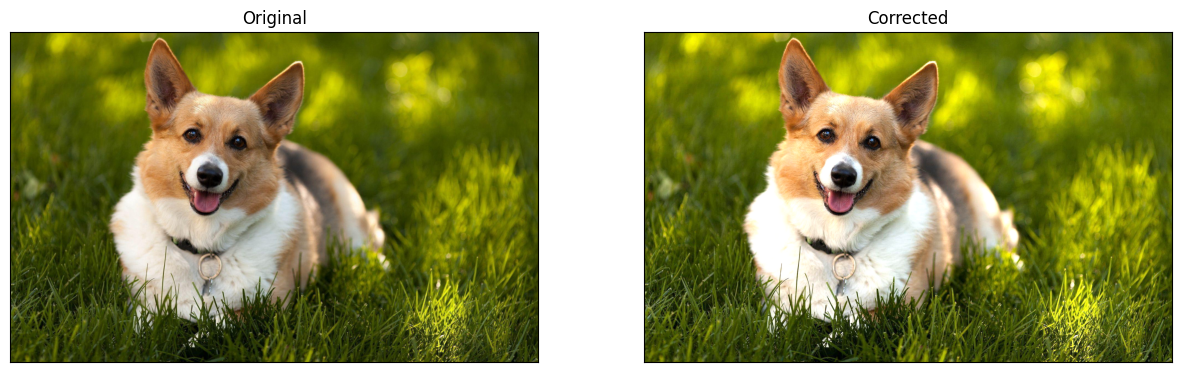

In [6]:
plt.figure(figsize=(15, 12))

# Sharpen
dst = make_filter([[-0.1, -0.1, -0.1],
                  [-0.1, 2, -0.1],
                  [-0.1, -0.1, -0.1]])

plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.xticks([]), plt.yticks([]);
plt.subplot(122), plt.imshow(dst), plt.title('Corrected')
plt.xticks([]), plt.yticks([])

(([], []), ([], []))

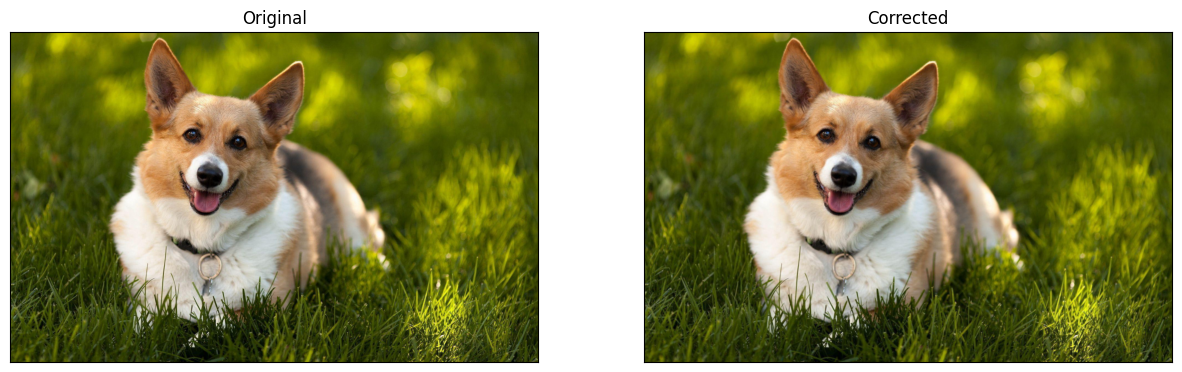

In [7]:
plt.figure(figsize=(15, 12))

# Gaussian Blur
dst = make_filter([[1/16, 1/8, 1/16],
                  [1/8, 1/4, 1/8],
                  [1/16, 1/8, 1/16]])


plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(dst), plt.title('Corrected')
plt.xticks([]), plt.yticks([])

(([], []), ([], []))

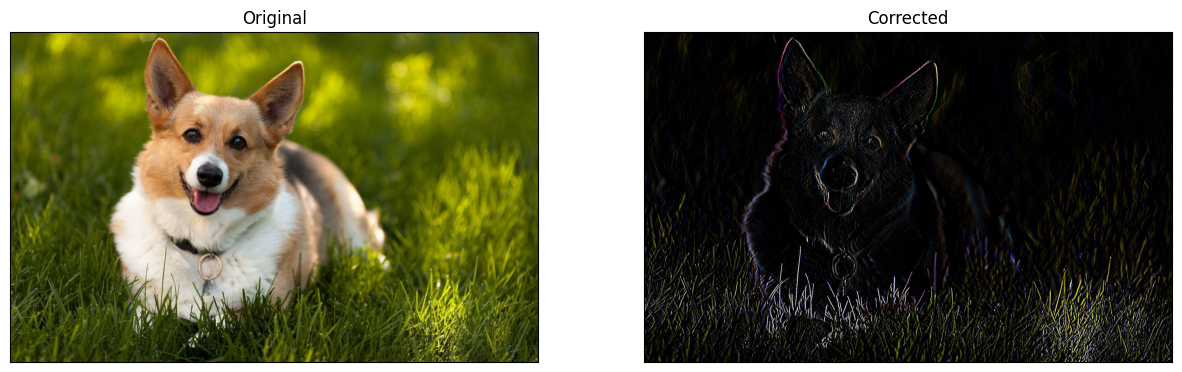

In [8]:
plt.figure(figsize=(15, 12))

# Left Sobel Filter
dst = make_filter([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])

plt.subplot(121), plt.imshow(img, ), plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(dst), plt.title('Corrected')
plt.xticks([]), plt.yticks([])

(([], []), ([], []))

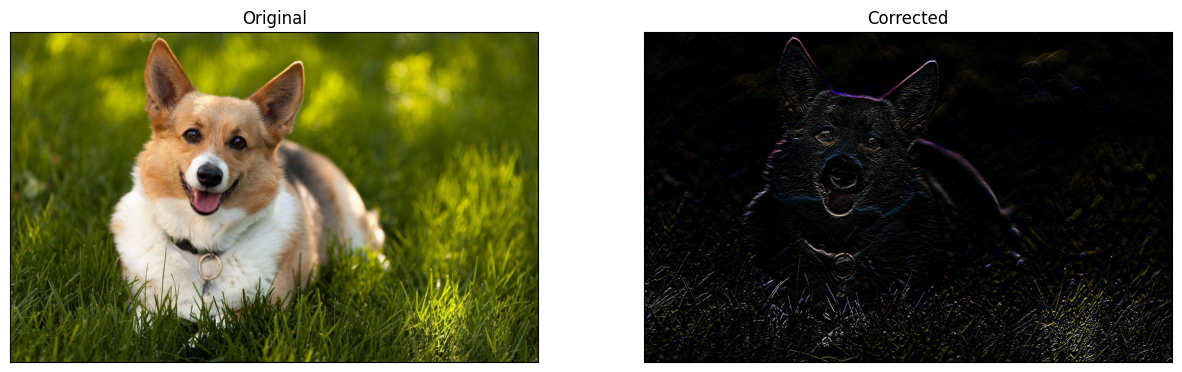

In [9]:
plt.figure(figsize=(15, 12))

# Right Sobel Filter

dst = make_filter([[-1, -2, -1],
                  [0, 0, 0],
                  [1, 2, 1]])

plt.subplot(121), plt.imshow(img, ), plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(dst), plt.title('Corrected')
plt.xticks([]), plt.yticks([])

## Task №2. FashionMNIST.

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

In [50]:
class CFG:

  api = ""
  project = "one_more_conv"
  entity = "dimildizio"
  num_epochs = 10
  train_batch_size = 64
  test_batch_size = 512
  num_workers = 2
  lr = 0.0001
  seed = 42
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
  wandb = False


  @classmethod
  def get_params(cls):
    params = {'epochs':cls.num_epochs, 'train_batch': cls.train_batch_size, 'test_batch': cls.test_batch_size,
          'num_workers': cls.num_workers, 'lr':cls.lr, 'seed': cls.seed, 'classes':len(cls.classes)}
    return params


  @classmethod
  def log_wnb(cls, model, config):
    if cls.wandb:
      os.environ['WANDB_API_KEY'] = cls.api
      wandb.init(project= cls.project, entity=cls.entity, reinit=True, config=config)
      wandb.watch(model, log='all')


  @classmethod
  def log_step(cls, name, loss, acc):
    if cls.wandb:
      wandb.log({name+'_loss':loss,
                 name+'_accuracy':acc})


  @classmethod
  def seed_all(cls):
    random.seed(cls.seed)
    np.random.seed(cls.seed)
    os.environ['PYTHONHASHSEDD'] = str(cls.seed)
    torch.manual_seed(cls.seed)
    torch.cuda.manual_seed(cls.seed)
    torch.backends.cudnn.determetistic = True
    torch.backends.cudnn.benchmark = False


  @classmethod
  def mainloop_decorator(cls, func):
    def wrapper(*args, **kwargs):
      params = cls.get_params()
      cls.log_wnb(args[0], params)
      result = func(*args, **kwargs)
      if cls.wandb:
        wandb.finish()
      return result
    return wrapper


  @staticmethod
  def put_model(model):
    cuda = torch.cuda.is_available()
    device = torch.device('cuda' if cuda else 'cpu')
    model.to(device)


42

In [12]:
#create a dict of classes
def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                          shuffle=True, num_workers=CFG.num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=16,
                                         shuffle=False, num_workers=CFG.num_workers)

100%|██████████| 26421880/26421880 [00:01<00:00, 19616996.68it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 327259.87it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6202815.44it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14394851.33it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



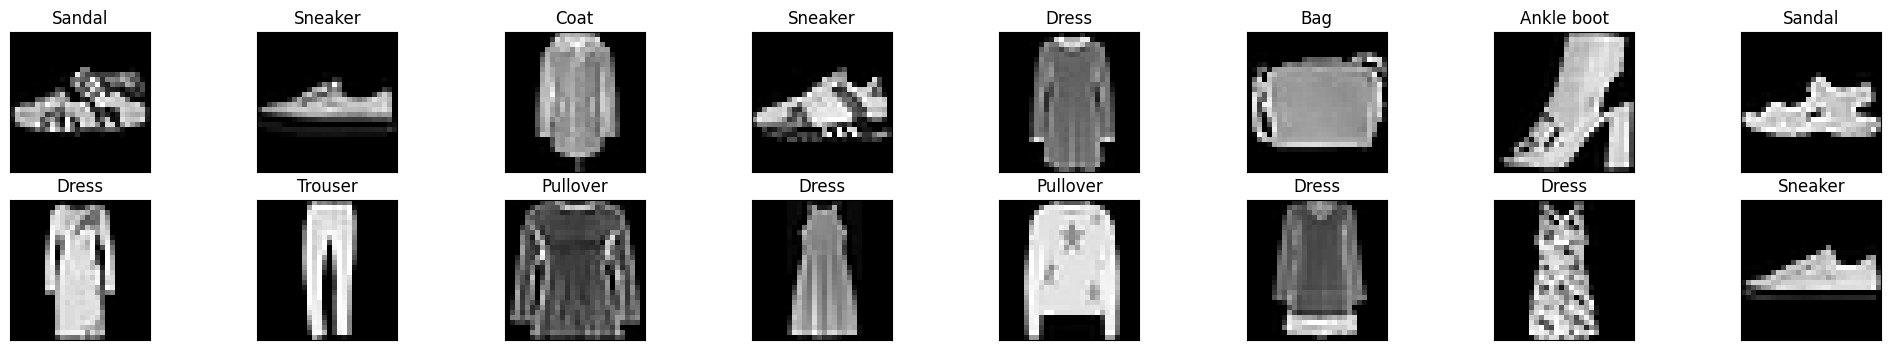

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, int(16/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # Add a label below each image
    ax.set_title(CFG.classes[labels[idx].item()])

In [53]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, constant_weight=None,
                 normal=False, xavier_uniform=False, he_normal=False
                ):
        super(LeNet5, self).__init__()

        self.conv_size = conv_size

        if activation == 'tanh':
          activation_func = nn.Tanh()
        elif activation == 'relu':
          activation_func = nn.ReLU()
        else:
          raise NotImplementedError
        self.act1 = activation_func
        self.act2 = activation_func
        self.act3 = activation_func
        self.act4 = activation_func

        if pooling == 'avg':
          pool = nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
          pool = nn.MaxPool2d(stride=2, kernel_size=2)
        else:
          raise NotImplementedError
        self.pool1 = pool
        self.pool2 = pool

        if conv_size == 5:
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                                kernel_size=5, padding=2)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                                 kernel_size = 5, padding=0)
        elif conv_size == 3:
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                                kernel_size=3, padding=1)
          self.conv1_2 = nn.Conv2d(in_channels=6, out_channels=6,
                                kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                                kernel_size=3, padding=0)
          self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16,
                                kernel_size=3, padding=0)
        else:
          raise NotImplementedError

        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


        #could have used a switchcase custom implementation with dict
        if constant_weight is not None:
          #constants. slow convergence, symmetric updates
          nn.init.constant_(self.conv1.weight)
          nn.init.constant_(self.conv2.weight)
          if self.conv_size == 3:
            nn.init.constant_(self.conv1_2.weight)
            nn.init.constant_(self.conv2_2.weight)
          nn.init.constant_(self.fc1.weight)
          nn.init.constant_(self.fc2.weight)
          nn.init.constant_(self.fc3.weight)

        if normal:
          #normal dist. zero mean. randomness but problem on in\out puts num and vanishing\exploding grad
          nn.init.normal_(self.conv1.weight)
          nn.init.normal_(self.conv2.weight)
          if self.conv_size == 3:
            nn.init.normal_(self.conv1_2.weight)
            nn.init.normal_(self.conv2_2.weight)
          nn.init.normal_(self.fc1.weight)
          nn.init.normal_(self.fc2.weight)
          nn.init.normal_(self.fc3.weight)

        if xavier_uniform:
          #uniform distribution, scalable
          nn.init.xavier_uniform_(self.conv1.weight)
          nn.init.xavier_uniform_(self.conv2.weight)
          if self.conv_size == 3:
            nn.init.xavier_uniform_(self.conv1_2.weight)
            nn.init.xavier_uniform_(self.conv2_2.weight)
          nn.init.xavier_uniform_(self.fc1.weight)
          nn.init.xavier_uniform_(self.fc2.weight)
          nn.init.xavier_uniform_(self.fc3.weight)

        if he_normal:
          #update of xavier, designed for ReLU
          nn.init.kaiming_normal_(self.conv1.weight)
          nn.init.kaiming_normal_(self.conv2.weight)
          if self.conv_size == 3:
            nn.init.kaiming_normal_(self.conv1_2.weight)
            nn.init.kaiming_normal_(self.conv2_2.weight)
          nn.init.kaiming_normal_(self.fc1.weight)
          nn.init.kaiming_normal_(self.fc2.weight)
          nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
      if self.conv_size == 5:
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
      elif self.conv_size == 3:
        x = self.pool1(self.act1(self.conv1_2(self.conv1(x))))
        x = self.pool2(self.act2(self.conv2_2(self.conv2(x))))

      x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
      x = self.act3(self.fc1(x))
      x = self.act4(self.fc2(x))
      x = self.fc3(x)
      return x


In [95]:

def train(model, optimizer, data=train_loader, criterion=nn.CrossEntropyLoss, epochs=CFG.num_epochs, wandb_flag=CFG.wandb):
  model.train()
  criterion = criterion()
  for epoch in range(epochs):
    current_loss = 0
    correct = 0
    samples_total = 0
    for num, batch in enumerate(tqdm_notebook(data)):
      optimizer.zero_grad()
      X, y = batch
      y_pred = model(X)

      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()

      pred = y_pred.argmax(dim=1, keepdim = True)
      correct += pred.eq(y.view_as(pred)).sum().item()
      current_loss += loss.item()
      samples_total += y.size(0)

      if not(num % (data.dataset.data.shape[0] // CFG.train_batch_size)):
        print(f'Epoch: {epoch+1}, loss: {round(current_loss, 3)}')
      CFG.log_step('train', loss, correct / samples_total)
    eval_model(model)


def eval_model(model, data = test_loader):
  model.eval()
  criterion = nn.CrossEntropyLoss()
  correct, samples_total, loss_total = 0, 0, 0.0
  class_correct, class_total = [0]*10, [0]*10
  with torch.no_grad():
    for batch in data:
      X,y = batch
      y_pred = model(X)
      loss = criterion(y_pred, y)

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
      loss_total += loss.item()
      samples_total += y.size(0)

      _, predicted = torch.max(y_pred, 1)
      c= (predicted == y).squeeze()
      for img_num in range(len(y)):
        label = y[img_num]
        class_correct[label] += c[img_num].item()
        class_total[label] += 1

    acc = correct / samples_total
    CFG.log_step('test', loss_total, acc)
    results = []
    for result_num in range(len(CFG.classes)):
        result = 100 * class_correct[result_num] / class_total[result_num]
        results.append(result)
        print(f'Accuracy of {CFG.classes[result_num]}: {results[result_num]}%')


@CFG.mainloop_decorator
def mainloop(model, optimizer, *args, **kwargs):
  CFG.put_model(model)
  train(model, optimizer, *args, **kwargs)
  eval_model(model, *args, **kwargs)
  return model

In [94]:
model = LeNet5(activation = 'relu', conv_size=5, he_normal=True)
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
trained = mainloop(model, optimizer)

<ipython-input-91-bd2fd2811beb>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num, batch in enumerate(tqdm_notebook(data)):


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 1, loss: 4.737
Epoch: 1, loss: 873.696
Epoch: 1, loss: 1421.446
Epoch: 1, loss: 1904.815
Epoch: 1, loss: 2362.734
Accuracy of T-shirt/top: 84.4%
Accuracy of Trouser: 94.2%
Accuracy of Pullover: 60.9%
Accuracy of Dress: 85.6%
Accuracy of Coat: 82.9%
Accuracy of Sandal: 92.2%
Accuracy of Shirt: 43.2%
Accuracy of Sneaker: 89.2%
Accuracy of Bag: 95.4%
Accuracy of Ankle boot: 95.2%


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 2, loss: 0.573
Epoch: 2, loss: 431.198
Epoch: 2, loss: 829.061
Epoch: 2, loss: 1228.752
Epoch: 2, loss: 1616.106
Accuracy of T-shirt/top: 83.7%
Accuracy of Trouser: 96.0%
Accuracy of Pullover: 62.4%
Accuracy of Dress: 88.4%
Accuracy of Coat: 88.1%
Accuracy of Sandal: 92.1%
Accuracy of Shirt: 45.3%
Accuracy of Sneaker: 90.8%
Accuracy of Bag: 97.3%
Accuracy of Ankle boot: 96.3%


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch: 3, loss: 0.516
Epoch: 3, loss: 372.924
Epoch: 3, loss: 737.84
Epoch: 3, loss: 1099.376
Epoch: 3, loss: 1441.002
Accuracy of T-shirt/top: 79.6%
Accuracy of Trouser: 94.8%
Accuracy of Pullover: 73.7%
Accuracy of Dress: 89.8%
Accuracy of Coat: 83.1%
Accuracy of Sandal: 87.7%
Accuracy of Shirt: 58.9%
Accuracy of Sneaker: 97.1%
Accuracy of Bag: 97.1%
Accuracy of Ankle boot: 93.9%
Accuracy of T-shirt/top: 79.6%
Accuracy of Trouser: 94.8%
Accuracy of Pullover: 73.7%
Accuracy of Dress: 89.8%
Accuracy of Coat: 83.1%
Accuracy of Sandal: 87.7%
Accuracy of Shirt: 58.9%
Accuracy of Sneaker: 97.1%
Accuracy of Bag: 97.1%
Accuracy of Ankle boot: 93.9%


In [96]:
summary(model=model,
        input_size=(CFG.train_batch_size, 1, 28, 28)
        col_names=["input_size", "output_size", "num_params", "trainable"]
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
LeNet5                                   [64, 1, 28, 28]      [64, 10]             --                   True
├─Conv2d: 1-1                            [64, 1, 28, 28]      [64, 6, 28, 28]      156                  True
├─ReLU: 1-2                              [64, 6, 28, 28]      [64, 6, 28, 28]      --                   --
├─AvgPool2d: 1-3                         [64, 6, 28, 28]      [64, 6, 14, 14]      --                   --
├─Conv2d: 1-4                            [64, 6, 14, 14]      [64, 16, 10, 10]     2,416                True
├─ReLU: 1-5                              [64, 16, 10, 10]     [64, 16, 10, 10]     --                   --
├─AvgPool2d: 1-6                         [64, 16, 10, 10]     [64, 16, 5, 5]       --                   --
├─Linear: 1-7                            [64, 400]            [64, 120]            48,120               True
├─ReLU: 1-8           